In [1]:
#%pip install --upgrade pip
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
#%pip install timm tqdm scikit-learn
#%pip install -U timm tqdm scikit-learn
#%pip install ruamel-yaml

In [2]:
import os, math, time, random
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import amp
from torchvision import datasets, transforms
from tqdm.auto import tqdm

import timm
from timm.loss import SoftTargetCrossEntropy
from timm.data import Mixup
from timm.utils import ModelEmaV2
from timm.scheduler import CosineLRScheduler

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
torch.backends.cudnn.benchmark = True

Device: cuda


In [3]:
train_dir = r"C:\Users\Liang\OneDrive - Nanyang Technological University\Documents\AIDM\datasets\train"
val_dir   = r"C:\Users\Liang\OneDrive - Nanyang Technological University\Documents\AIDM\datasets\val"

img_size = 224
epochs = 20
batch_size = 64
learning_rate = 3e-4
weight_decay = 0.05
warmup_epochs = 5
label_smoothing = 0.1
mixup_alpha = 0.2
cutmix_alpha = 0.2
random_erasing_p = 0.1

best_ckpt_path = "convnext_tiny_best.pth"
model_name = "convnext_tiny.fb_in22k_ft_in1k"

In [4]:
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    transforms.RandomErasing(p=random_erasing_p, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
])

val_tfms = transforms.Compose([
    transforms.Resize(int(img_size * 1.14)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=val_tfms)
classes = train_ds.classes
num_classes = len(classes)
print('Classes:', classes)

num_workers = 2
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=False,
    prefetch_factor=1,
    persistent_workers=False
)

val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
    prefetch_factor=1,
    persistent_workers=False
)

len(train_ds), len(val_ds), num_classes

Classes: ['cat', 'dog']


(20000, 5000, 2)

In [5]:
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
model.to(device)

mixup_fn = Mixup(
    mixup_alpha=mixup_alpha,
    cutmix_alpha=cutmix_alpha,
    label_smoothing=label_smoothing,
    num_classes=num_classes
)

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
num_steps = len(train_dl)
scheduler = CosineLRScheduler(
    optimizer,
    t_initial=(epochs - warmup_epochs) * num_steps,
    lr_min=1e-6,
    warmup_t=warmup_epochs * num_steps,
    warmup_lr_init=1e-6,
    k_decay=1.0,
)
ema = ModelEmaV2(model, decay=0.9999, device=device)

scaler = amp.GradScaler(device_type)

criterion_train = SoftTargetCrossEntropy()

criterion_val = nn.CrossEntropyLoss()

def current_lr(opt):
    for g in opt.param_groups:
        return g["lr"]

In [6]:
def train_one_epoch(epoch):
    model.train()
    total, loss_sum = 0, 0.0
    pbar = tqdm(enumerate(train_dl), total=len(train_dl), desc=f"Epoch {epoch+1}/{epochs} [train]")
    for step, (x, y) in pbar:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        x, y_mix = mixup_fn(x, y)  # soft labels

        optimizer.zero_grad(set_to_none=True)
        with amp.autocast(device_type=device_type):
            logits = model(x)
            loss = criterion_train(logits, y_mix)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        ema.update(model)
        scheduler.step(epoch * len(train_dl) + step)

        bs_now = x.size(0)
        loss_sum += loss.item() * bs_now
        total += bs_now
        pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{current_lr(optimizer):.2e}")

    return loss_sum / max(total, 1)

@torch.no_grad()
def evaluate(epoch=0, use_ema=True):
    m = ema.module if use_ema else model
    m.eval()
    total, correct, loss_sum = 0, 0, 0.0
    pbar = tqdm(val_dl, total=len(val_dl), desc=f"Epoch {epoch+1}/{epochs} [val] ", leave=False)
    for x, y in pbar:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        with amp.autocast(device_type=device_type):
            logits = m(x)
            loss = criterion_val(logits, y)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        loss_sum += loss.item() * x.size(0)
        total += x.size(0)
    return loss_sum / max(total, 1), correct / max(total, 1)

In [7]:
best_acc = 0.0
for epoch in range(epochs):
    t0 = time.time()
    train_loss = train_one_epoch(epoch)
    val_loss, val_acc = evaluate(epoch=epoch)
    dt = time.time() - t0

    tqdm.write(f"Epoch {epoch+1:>3}/{epochs} | train {train_loss:.4f} | val {val_loss:.4f} | acc {val_acc:.4f} | {dt:.1f}s")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(ema.module.state_dict(), best_ckpt_path)
        tqdm.write(f"  ✓ Saved new best to {best_ckpt_path} (acc {best_acc:.4f})")

print('Best val acc:', best_acc)

Epoch 1/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/20 [val] :   0%|          | 0/79 [00:14<?, ?it/s]

Epoch   1/20 | train 0.3771 | val 0.5534 | acc 0.7264 | 437.8s
  ✓ Saved new best to convnext_tiny_best.pth (acc 0.7264)


Epoch 2/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/20 [val] :   0%|          | 0/79 [00:17<?, ?it/s]

Epoch   2/20 | train 0.3322 | val 0.5055 | acc 0.7778 | 396.4s
  ✓ Saved new best to convnext_tiny_best.pth (acc 0.7778)


Epoch 3/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/20 [val] :   0%|          | 0/79 [00:14<?, ?it/s]

Epoch   3/20 | train 0.3368 | val 0.4489 | acc 0.8298 | 262.6s
  ✓ Saved new best to convnext_tiny_best.pth (acc 0.8298)


Epoch 4/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/20 [val] :   0%|          | 0/79 [00:16<?, ?it/s]

Epoch   4/20 | train 0.3308 | val 0.3849 | acc 0.8844 | 242.8s
  ✓ Saved new best to convnext_tiny_best.pth (acc 0.8844)


Epoch 5/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/20 [val] :   0%|          | 0/79 [00:13<?, ?it/s]

Epoch   5/20 | train 0.3438 | val 0.3201 | acc 0.9332 | 259.5s
  ✓ Saved new best to convnext_tiny_best.pth (acc 0.9332)


Epoch 6/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6/20 [val] :   0%|          | 0/79 [00:19<?, ?it/s]

Epoch   6/20 | train 0.3188 | val 0.2626 | acc 0.9624 | 269.3s
  ✓ Saved new best to convnext_tiny_best.pth (acc 0.9624)


Epoch 7/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7/20 [val] :   0%|          | 0/79 [00:13<?, ?it/s]

Epoch   7/20 | train 0.3174 | val 0.2173 | acc 0.9756 | 265.3s
  ✓ Saved new best to convnext_tiny_best.pth (acc 0.9756)


Epoch 8/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8/20 [val] :   0%|          | 0/79 [00:15<?, ?it/s]

Epoch   8/20 | train 0.3243 | val 0.1815 | acc 0.9842 | 271.8s
  ✓ Saved new best to convnext_tiny_best.pth (acc 0.9842)


Epoch 9/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9/20 [val] :   0%|          | 0/79 [00:15<?, ?it/s]

Epoch   9/20 | train 0.3291 | val 0.1535 | acc 0.9886 | 262.2s
  ✓ Saved new best to convnext_tiny_best.pth (acc 0.9886)


Epoch 10/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10/20 [val] :   0%|          | 0/79 [00:15<?, ?it/s]

Epoch  10/20 | train 0.3136 | val 0.1322 | acc 0.9920 | 260.5s
  ✓ Saved new best to convnext_tiny_best.pth (acc 0.9920)


Epoch 11/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11/20 [val] :   0%|          | 0/79 [00:17<?, ?it/s]

Epoch  11/20 | train 0.3187 | val 0.1159 | acc 0.9936 | 268.1s
  ✓ Saved new best to convnext_tiny_best.pth (acc 0.9936)


Epoch 12/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12/20 [val] :   0%|          | 0/79 [00:15<?, ?it/s]

Epoch  12/20 | train 0.3157 | val 0.1033 | acc 0.9950 | 258.3s
  ✓ Saved new best to convnext_tiny_best.pth (acc 0.9950)


Epoch 13/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13/20 [val] :   0%|          | 0/79 [00:15<?, ?it/s]

Epoch  13/20 | train 0.3247 | val 0.0938 | acc 0.9956 | 262.2s
  ✓ Saved new best to convnext_tiny_best.pth (acc 0.9956)


Epoch 14/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14/20 [val] :   0%|          | 0/79 [00:19<?, ?it/s]

Epoch  14/20 | train 0.3156 | val 0.0864 | acc 0.9968 | 280.5s
  ✓ Saved new best to convnext_tiny_best.pth (acc 0.9968)


Epoch 15/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15/20 [val] :   0%|          | 0/79 [00:18<?, ?it/s]

Epoch  15/20 | train 0.3214 | val 0.0806 | acc 0.9968 | 293.3s


Epoch 16/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16/20 [val] :   0%|          | 0/79 [00:15<?, ?it/s]

Epoch  16/20 | train 0.3205 | val 0.0762 | acc 0.9970 | 270.8s
  ✓ Saved new best to convnext_tiny_best.pth (acc 0.9970)


Epoch 17/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17/20 [val] :   0%|          | 0/79 [00:15<?, ?it/s]

Epoch  17/20 | train 0.3145 | val 0.0726 | acc 0.9970 | 262.0s


Epoch 18/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18/20 [val] :   0%|          | 0/79 [00:16<?, ?it/s]

Epoch  18/20 | train 0.3192 | val 0.0699 | acc 0.9970 | 261.0s


Epoch 19/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19/20 [val] :   0%|          | 0/79 [00:17<?, ?it/s]

Epoch  19/20 | train 0.3106 | val 0.0677 | acc 0.9970 | 268.9s


Epoch 20/20 [train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20/20 [val] :   0%|          | 0/79 [00:15<?, ?it/s]

Epoch  20/20 | train 0.3326 | val 0.0659 | acc 0.9972 | 265.8s
  ✓ Saved new best to convnext_tiny_best.pth (acc 0.9972)
Best val acc: 0.9972


C:\Users\Liang\AppData\Local\Temp\ipykernel_13440\930448117.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(best_ckpt_path, map_location=device)


Testing:   0%|          | 0/8 [00:01<?, ?it/s]


Test accuracy: 1.0000

Classification report:
              precision    recall  f1-score   support

         cat     1.0000    1.0000    1.0000       241
         dog     1.0000    1.0000    1.0000       259

    accuracy                         1.0000       500
   macro avg     1.0000    1.0000    1.0000       500
weighted avg     1.0000    1.0000    1.0000       500

Confusion matrix (counts):
 [[241   0]
 [  0 259]]

Confusion matrix (row-normalized):
 [[1. 0.]
 [0. 1.]]


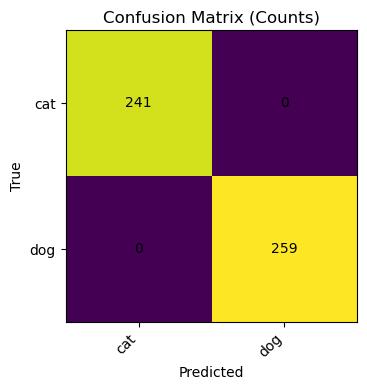

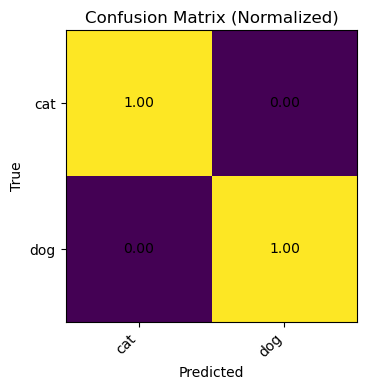


Saved predictions CSV to: test_predictions.csv
    id pred_label true_label
0    1        cat        cat
1  100        cat        cat
2  101        cat        cat
3  103        cat        cat
4  107        cat        cat
5  108        cat        cat
6  110        cat        cat
7  111        cat        cat
8   12        cat        cat
9  121        cat        cat


In [8]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

test_dir = r"C:\Users\Liang\OneDrive - Nanyang Technological University\Documents\AIDM\datasets\test"
assert os.path.isdir(test_dir), f"Test dir not found: {test_dir}"

test_tfms = val_tfms

test_ds = datasets.ImageFolder(test_dir, transform=test_tfms)
test_classes = test_ds.classes
assert test_classes == classes, f"Class order mismatch! train/val: {classes}, test: {test_classes}"

test_dl = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=min(8, os.cpu_count() or 4),
    pin_memory=False
)

if not os.path.isfile(best_ckpt_path):
    raise FileNotFoundError(f"Best checkpoint not found at {best_ckpt_path}. Train first or set correct path.")

def load_weights_safely(path, device):
    try:
        return torch.load(path, map_location=device, weights_only=True)
    except TypeError:
        return torch.load(path, map_location=device)

state = load_weights_safely(best_ckpt_path, device)
ema.module.load_state_dict(state)
infer_model = ema.module.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    pbar = tqdm(test_dl, total=len(test_dl), desc="Testing")
    for x, y in pbar:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        with amp.autocast(device_type=device_type):
            logits = infer_model(x)
        preds = logits.argmax(1)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())

y_true = np.concatenate(all_targets)
y_pred = np.concatenate(all_preds)

acc = (y_true == y_pred).mean()
print(f"\nTest accuracy: {acc:.4f}\n")
print("Classification report:")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
cm_norm = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True).clip(min=1)

print("Confusion matrix (counts):\n", cm)
print("\nConfusion matrix (row-normalized):\n", np.round(cm_norm, 3))

plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Counts)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(classes)), labels=classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
plt.imshow(cm_norm, interpolation='nearest')
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(classes)), labels=classes)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha='center', va='center')
plt.tight_layout()
plt.show()

filepaths = [p for p, _ in test_ds.samples]
ids = [Path(p).stem for p in filepaths]

pred_labels = [classes[i] for i in y_pred]
true_labels = [classes[i] for i in y_true]

df_out = pd.DataFrame({
    "id": ids,
    "pred_label": pred_labels,
    "true_label": true_labels,
})

csv_path = os.path.join(os.path.dirname(best_ckpt_path), "test_predictions.csv")
df_out.to_csv(csv_path, index=False, encoding="utf-8")
print(f"\nSaved predictions CSV to: {csv_path}")
print(df_out.head(10))